# DCGAN For Car Images

In [1]:
!nvidia-smi

Thu Dec 12 13:50:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import Data

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    os.chdir('/content')
    if not os.path.isdir('/content/EVA-2-Group/'):
        !git clone https://github.com/sambitdash/EVA-2-Group.git
    os.chdir('/content/EVA-2-Group/Session-19')
    !pwd
    
    #!git config user.email "sambitdash@gmail.com"
    #!git config user.name "Sambit Kumar Dash"
    #!git config user.password "your password"
    !git status

Cloning into 'EVA-2-Group'...
remote: Enumerating objects: 1189, done.
remote: Counting objects: 100% (1189/1189), done.
remote: Compressing objects: 100% (1160/1160), done.
remote: Total 2285 (delta 55), reused 1135 (delta 20), pack-reused 1096
Receiving objects: 100% (2285/2285), 593.57 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Checking out files: 100% (2039/2039), done.
/content/EVA-2-Group/Session-19
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


## Imports

In [0]:
%tensorflow_version 1.x

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Flatten, Reshape, Dense, Concatenate, Conv2DTranspose, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, MaxPool2D, Dropout
from tensorflow.keras.layers import add, Input, Dense, Flatten, GlobalAvgPool2D, GlobalAvgPool1D, LeakyReLU
from tensorflow.keras.initializers import zeros
from tensorflow.keras.initializers import RandomNormal

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Resize Images

In [5]:
import cv2
import os
import numpy as np
from os import listdir
from os.path import join

car_types = ['hatch', 'sedan', 'suv']

def resize_image(img, size=(64,64)):

    h, w = img.shape[:2]

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        c = img.shape[2]
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

spath, dpath = join('data', 'cars'), join('data', 'norm')

if not os.path.isdir(dpath):
    os.mkdir(dpath)

imgs = {}


for ct in car_types:
    sp, dp = join(spath, ct), join(dpath, ct)
    alen = 1024
    imgs[ct] = np.zeros((1024, 64, 64, 3))
    if not os.path.isdir(dp):
        os.mkdir(dp)
    tlen = 0
    for f in listdir(sp):
        sf, df = join(sp, f), join(dp, f)
        img = cv2.imread(sf)
        img = resize_image(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tlen += 1
        if tlen > alen:
            imgs[ct] = np.append(imgs[ct], np.zeros((1024, 64, 64, 3)))
            alen += 1024
        imgs[ct][tlen-1] = img
    imgs[ct] = imgs[ct][:tlen]
    print(imgs[ct].shape)

(332, 64, 64, 3)
(410, 64, 64, 3)
(337, 64, 64, 3)


## Generate More Data Using Augmentation

In [0]:
#trainX = imgs['hatch']
# can include suv images as well. Let's try with only two categories.
data = np.append(imgs['hatch'], imgs['sedan'], axis=0)

In [7]:
data.shape

(742, 64, 64, 3)

In [0]:
from tensorflow.keras import utils 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(data)

trainX = data

for i in range(9):
    iterate = datagen.flow(data, batch_size=len(data), shuffle=True)
    x = iterate.next()
    trainX = np.append(trainX, x, axis=0)

In [9]:
trainX.shape

(7420, 64, 64, 3)

## Convert the data

Convert the data from [0,255] to [-1, 1].
Note that generator uses tanh activation.

In [0]:
def convert_input_data(X):
  X = X.astype('float32')

  # shift the data from [0, 255] to [-1, 1]
  X = (X - 127.5) / 127.5
  return X  

In [0]:
trainX = convert_input_data(trainX)

## Build Discriminator

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (3,3), padding= 'same' , input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  #downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(512, (3,3), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation= 'sigmoid' ))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss= 'binary_crossentropy' , optimizer=opt, metrics=[ 'accuracy' ])
  return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_2

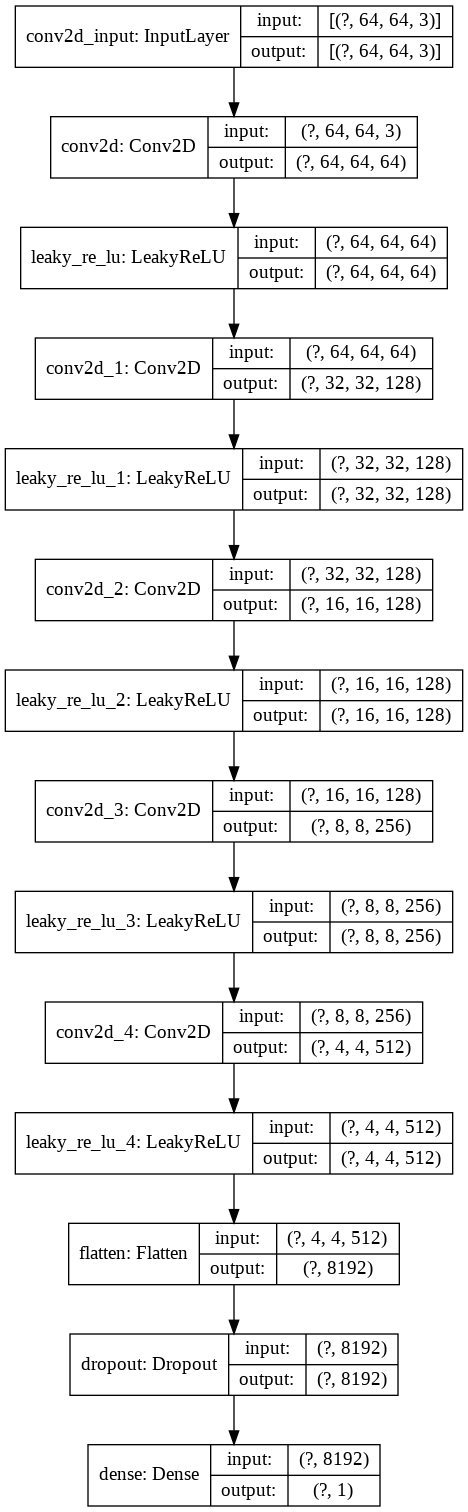

In [13]:
# define model
D = define_discriminator()
# summarize the model
D.summary()
# plot the model
plot_model(D, to_file= 'discriminator_plot.png' , show_shapes=True, show_layer_names=True)

## Build Generator

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
                                                                                                             
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 64x64
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= 'same' ))
  model.add(LeakyReLU(alpha=0.2)) 
  # output layer
  model.add(Conv2D(3, (3,3), activation= 'tanh' , padding= 'same' ))
  return model

In [0]:
latent_dim = 100

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)      

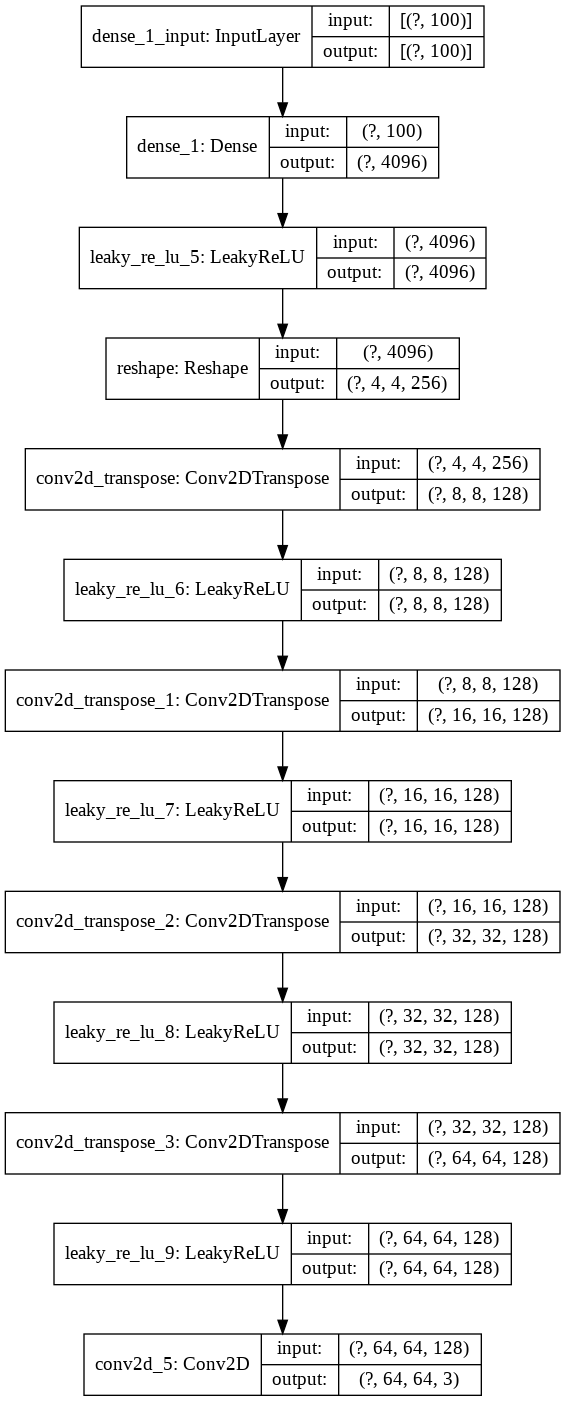

In [16]:
# create the generator
G = define_generator(latent_dim)
# summarize the model
G.summary()
# plot the model
plot_model(G, to_file= 'generator_plot.png' , show_shapes=True, show_layer_names=True)

## Define GAN

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss= binary_crossentropy , optimizer=opt)
  return model

In [0]:
# create the gan
gan_model = define_gan(G, D)

## Training Utilities

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate  real  class labels (1)
  y = np.ones((n_samples, 1))
  return X, y

In [0]:
def generate_latent_points(latent_dim, n_samples, n_classes=2):
  # get the random points from normal distribution
  x_input = np.random.randn(latent_dim * n_samples)
  
  data = x_input.reshape(n_samples, latent_dim)
  return (data)

In [0]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  # get the latent space
  data   = generate_latent_points(latent_dim, n_samples)

  # get the images and their labels
  images = g_model.predict(data)

  # tag them as fake (which is class 0 for discriminator)
  fake = np.zeros((n_samples, 1))

  return(images, fake)

## Create Directory To Store Generated Imges

In [22]:
!pwd

/content/EVA-2-Group/Session-19


In [0]:
!mkdir gen_images

In [0]:
os.chdir('gen_images')

In [25]:
!pwd

/content/EVA-2-Group/Session-19/gen_images


In [0]:
# At regular intervals during training process
# generate images from generator
# and also, save model
#
def summarize_performance(step, gen_model, latent_dim, n_samples=25):
  # get the generated images
  fake_images, _ = generate_fake_samples(gen_model, latent_dim, n_samples)

  # scale the images from [-1,1] to [0,1]
  fake_images = (fake_images + 1) / 2.0

  # plot images
  for i in range(25):
    plt.subplot(5, 5, 1+i)
    plt.axis('off')
    plt.imshow(fake_images[i])

  # save the plot to file
  filename = 'gen_plot_%04d.png' % (step+1)
  plt.savefig(filename)
  plt.close()

  # save the model as well
  model_file = 'gen_model_%04d.hdf5' % (step+1)
  #gen_model.save(model_file)
  print('Saved: %s and %s' % (filename, model_file))

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, trainX, latent_dim, n_epochs=100, n_batch=64):
  # calculate the number of batches per training epoch
  bat_per_epo = int(trainX.shape[0] / n_batch)

  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  print('Total steps:', n_steps)

  # calculate the size of half a batch of samples
  half_batch = int(n_batch / 2)

  # manually enumerate epochs
  for i in range(n_steps):
    # get randomly selected  real  samples
    X_real, y_real = generate_real_samples(trainX, half_batch)

    # update discriminator model weights
    d_loss1, _ = d_model.train_on_batch(X_real, y_real)

    # generate  fake  examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

    # update discriminator model weights
    d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

    # prepare points in latent space as input for the generator
    X_gan = generate_latent_points(latent_dim, n_batch)

    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))

    # update the generator via the discriminator s error
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
    
    
    if (i+1) % (bat_per_epo * 1) == 0:
      # summarize loss on this batch
      print( '>%d, d1[%.3f], d2[%.3f], g[%.3f]'  % (i+1, d_loss1, d_loss2, g_loss))
      
    # evaluate the model performance every  epoch
    if (i+1) % (bat_per_epo * 10) == 0:
      summarize_performance(i, g_model, latent_dim)

## Traning

In [29]:
# train model
train(G, D, gan_model, trainX, latent_dim, n_epochs=10, n_batch=100)

Total steps: 740
>74, d1[0.175], d2[0.099], g[3.050]
>148, d1[0.000], d2[0.015], g[4.848]
>222, d1[0.250], d2[0.006], g[6.591]
>296, d1[0.062], d2[0.129], g[5.384]
>370, d1[0.380], d2[0.294], g[3.138]
>444, d1[0.155], d2[0.219], g[3.007]
>518, d1[0.195], d2[0.256], g[3.002]
>592, d1[0.330], d2[0.162], g[2.871]
>666, d1[0.110], d2[0.146], g[2.997]
>740, d1[0.335], d2[0.233], g[2.969]
Saved: gen_plot_0740.png and gen_model_0740.hdf5


In [0]:
# train model
train(G, D, gan_model, trainX, latent_dim, n_epochs=50, n_batch=100)

Total steps: 3700
>74, d1[0.039], d2[0.347], g[5.987]
>148, d1[0.191], d2[0.074], g[4.356]
>222, d1[0.032], d2[0.025], g[4.828]
>296, d1[0.189], d2[0.208], g[3.768]
>370, d1[0.214], d2[0.252], g[4.600]
>444, d1[0.869], d2[0.022], g[5.802]
>518, d1[0.364], d2[0.374], g[3.231]
>592, d1[0.439], d2[0.233], g[4.022]
>666, d1[0.207], d2[0.276], g[3.169]
>740, d1[0.353], d2[0.096], g[3.037]
Saved: gen_plot_0740.png and gen_model_0740.hdf5
>814, d1[0.216], d2[0.242], g[2.653]
>888, d1[0.322], d2[0.160], g[3.169]
>962, d1[0.209], d2[0.249], g[3.487]
>1036, d1[0.138], d2[0.104], g[5.033]
>1110, d1[0.211], d2[0.122], g[3.544]
>1184, d1[0.225], d2[0.080], g[4.322]
>1258, d1[0.196], d2[0.163], g[3.397]
>1332, d1[0.329], d2[0.147], g[3.613]
>1406, d1[0.213], d2[0.189], g[3.496]
>1480, d1[0.034], d2[0.234], g[3.878]
Saved: gen_plot_1480.png and gen_model_1480.hdf5
>1554, d1[0.366], d2[0.181], g[3.282]
>1628, d1[0.158], d2[0.326], g[3.913]
>1702, d1[0.187], d2[0.120], g[3.558]
>1776, d1[0.566], d2[0.0

In [0]:
train(G, D, gan_model, trainX, latent_dim, n_epochs=100, n_batch=50)

Total steps: 14800
>148, d1[0.202], d2[0.281], g[4.011]
>296, d1[0.118], d2[0.225], g[3.474]
>444, d1[0.487], d2[0.168], g[3.398]
>592, d1[0.295], d2[0.208], g[2.878]
>740, d1[0.360], d2[0.284], g[2.911]
>888, d1[0.109], d2[0.101], g[3.311]
>1036, d1[0.328], d2[0.153], g[2.840]
>1184, d1[0.311], d2[0.153], g[2.795]
>1332, d1[0.128], d2[0.078], g[3.592]
>1480, d1[0.170], d2[0.290], g[3.388]
Saved: gen_plot_1480.png and gen_model_1480.hdf5
>1628, d1[0.265], d2[0.052], g[4.264]
>1776, d1[0.205], d2[0.172], g[2.791]
>1924, d1[0.235], d2[0.051], g[3.348]
>2072, d1[0.160], d2[0.043], g[3.790]
>2220, d1[0.546], d2[0.105], g[3.562]
>2368, d1[0.304], d2[0.138], g[3.380]
>2516, d1[0.454], d2[0.168], g[2.069]
>2664, d1[0.143], d2[0.071], g[3.152]
>2812, d1[0.355], d2[0.115], g[3.199]
>2960, d1[0.108], d2[0.361], g[3.817]
Saved: gen_plot_2960.png and gen_model_2960.hdf5
>3108, d1[0.275], d2[0.219], g[2.978]
>3256, d1[0.025], d2[0.109], g[3.762]
>3404, d1[0.459], d2[0.226], g[2.679]
>3552, d1[0.155

In [0]:
gan_model.save('gan_model.hdf5')

In [0]:
D.save('D_model.hdf5')

In [0]:
G.save('G_model.hdf5')

## Train more

In [0]:
train(G, D, gan_model, trainX, latent_dim, n_epochs=200, n_batch=50)

Total steps: 29600
>148, d1[0.110], d2[0.013], g[4.973]
>296, d1[0.024], d2[0.008], g[5.797]
>444, d1[0.043], d2[0.020], g[6.013]
>592, d1[0.050], d2[0.442], g[6.879]
>740, d1[0.116], d2[0.133], g[6.224]
>888, d1[0.097], d2[0.639], g[5.251]
>1036, d1[0.047], d2[0.303], g[5.549]
>1184, d1[0.045], d2[0.015], g[6.069]
>1332, d1[0.017], d2[0.040], g[5.151]
>1480, d1[0.074], d2[0.103], g[3.805]
Saved: gen_plot_1480.png and gen_model_1480.hdf5
>1628, d1[0.186], d2[0.022], g[5.308]
>1776, d1[0.087], d2[0.127], g[5.957]
>1924, d1[0.169], d2[0.046], g[6.507]
>2072, d1[0.178], d2[0.093], g[4.529]
>2220, d1[0.015], d2[0.013], g[5.350]
>2368, d1[0.214], d2[0.039], g[5.573]
>2516, d1[0.002], d2[0.057], g[5.026]
>2664, d1[0.019], d2[0.067], g[5.414]
>2812, d1[0.055], d2[0.050], g[6.167]
>2960, d1[0.121], d2[0.039], g[6.386]
Saved: gen_plot_2960.png and gen_model_2960.hdf5
>3108, d1[0.264], d2[0.035], g[5.918]
>3256, d1[0.256], d2[0.039], g[3.852]
>3404, d1[0.028], d2[0.020], g[6.047]
>3552, d1[0.001

In [0]:
!pwd

/content/DCGAN


In [0]:
gan_model.save('gan_model.hdf5')
D.save('D_model.hdf5')
G.save('G_model.hdf5')

In [0]:
train(G, D, gan_model, trainX, latent_dim, n_epochs=100, n_batch=50)

Total steps: 14800
>148, d1[0.008], d2[0.078], g[6.812]
>296, d1[0.021], d2[0.061], g[7.010]
>444, d1[0.014], d2[0.098], g[7.225]
>592, d1[0.046], d2[0.056], g[9.040]
>740, d1[0.044], d2[0.051], g[6.655]
>888, d1[0.012], d2[0.005], g[8.671]
>1036, d1[0.066], d2[0.045], g[6.355]
>1184, d1[0.066], d2[0.128], g[7.066]
>1332, d1[0.014], d2[0.037], g[7.153]
>1480, d1[0.310], d2[0.093], g[8.324]
Saved: gen_plot_1480.png and gen_model_1480.hdf5
>1628, d1[0.052], d2[0.153], g[7.217]
>1776, d1[0.463], d2[0.176], g[5.124]
>1924, d1[0.066], d2[0.106], g[5.388]
>2072, d1[0.040], d2[0.285], g[6.298]
>2220, d1[0.071], d2[0.365], g[6.980]
>2368, d1[0.199], d2[0.119], g[5.826]
>2516, d1[0.049], d2[0.080], g[6.381]
>2664, d1[0.133], d2[0.016], g[5.960]
>2812, d1[0.053], d2[0.018], g[5.432]
>2960, d1[0.025], d2[0.008], g[7.651]
Saved: gen_plot_2960.png and gen_model_2960.hdf5
>3108, d1[0.016], d2[0.016], g[6.456]
>3256, d1[0.086], d2[0.053], g[6.901]
>3404, d1[0.032], d2[0.064], g[6.679]
>3552, d1[0.018

In [0]:
gan_model.save('gan_model.hdf5')
D.save('D_model.hdf5')
G.save('G_model.hdf5')